# Classificação de Emoções - Reconhecimento de Imagens
28.709 Exemplos de Imagens 48x48, 7 Tipos de emoções

<img src="https://i.imgur.com/lA3PkYX.png">




# 1. Importação dos dados

#### Instalando dataset da biblioteca kaggle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Istalando Kaggle

In [5]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Criando pasta na raiz

In [6]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


Definindo permissões para o arquivo de chave (Conta pessoal da Kaggle)

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [8]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Projetos/Projeto - Reconhecimento de Imagens')

Baixando o dataset

In [9]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


Descompactando o zip

In [10]:
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

unzip:  cannot find or open challenges-in-representation-learning-facial-expression-recognition-challenge.zip, challenges-in-representation-learning-facial-expression-recognition-challenge.zip.zip or challenges-in-representation-learning-facial-expression-recognition-challenge.zip.ZIP.


Excluindo zip criado

In [11]:
!rm challenges-in-representation-learning-facial-expression-recognition-challenge.zip

rm: cannot remove 'challenges-in-representation-learning-facial-expression-recognition-challenge.zip': No such file or directory


In [12]:
!ls

Checkpoints	   example_submission.csv  icml_face_data.csv	      test.csv
Documentação.gdoc  fer2013.tar.gz	   neural_emotion_face.ipynb  train.csv


#### Importando bibliotecas

In [90]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

#### Carregando dataset

In [15]:
df = pd.read_csv('icml_face_data.csv')
df.head(10)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,Training,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,Training,255 254 255 254 254 179 122 107 95 124 149 150...


Renomeando campos

In [16]:
df.rename(columns={' pixels': 'pixels', ' Usage': 'usage'}, inplace=True)
df.columns

Index(['emotion', 'usage', 'pixels'], dtype='object')

#2. Pré-Processamento dos dados

### Criando funções complementares

Função para preparar o array de imagens e categoria.

In [17]:
def preparar_dados(data):
  array_image = np.zeros(shape=(len(data), 48, 48)) #Cria um array tridimensional com blocos de 48x48 array([ [[], []], [[], []] ])
  array_category = np.array(list(map(int, data['emotion']))) #Cria uma lista de categorias por imagens

  for index, row in enumerate(data.index):
    image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ') #Cria um array numpy com os pixels do dataset

    image = np.reshape(image, (48, 48)) #Redimensiona a array imagem para ficar no formato 48x48
    array_image[index] = image #Altera o valor do array principal

  return array_image, array_category

Função para plotar imagens dinamicamente de uma categoria

In [18]:
def mostrar_categoria(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))  # Criar figura e eixos dinamicamente
    fig.subplots_adjust(hspace=0.2, wspace=0.2)  # Definir tamanho do plot

    for i, ax in enumerate(axs):
        idx = df[df['emotion']==label].index[i + random.randint(0, 100)] #Define aleatoriamente uma imagem daquela emoção no grafico
        image = Image.fromarray(np.uint8(train_images[idx][:, :, 0] * 255))  # Converter a matriz de pixels em uma imagem PIL
        ax.imshow(image, cmap='gray') #Cria a imagem
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show() #Mostra gráfico

### Definindo Treino, Teste e Validação

Criando dicionário de Categorias

In [19]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Separando dataset

In [20]:
train_image_array, train_image_label = preparar_dados(df[df['usage']=='Training'])
val_image_array, val_image_label = preparar_dados(df[df['usage']=='PrivateTest'])
test_image_array, test_image_label = preparar_dados(df[df['usage']=='PublicTest'])

Redimensionando e normalizando os valores da imagem

In [21]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1)) #48 de altura, 48 de largura e 1 canal de cor(escala de cinza)
train_images = train_images.astype('float32')/255 #Divide cada pixel pelo maior valor possivel(255) para normalizar os dados entre 0 e 1. (Otimização)

val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [22]:
train_labels = to_categorical(train_image_label) #Aplica o one-hot encoding, representados com vetores binários
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

Definindo peso de cada categoria


In [23]:
#Define o peso das categorias com base na distribuição no conjunto de treinamento. 
df_train_emotion = df[df['usage']=='Training']['emotion'] #Cria um dataframe com as emoções/categorias de treinamento
array_distribuicao = (((df_train_emotion.value_counts()).sort_index()) / len(df_train_emotion)).to_list() #Distribuição total em um arary
peso_categoria = dict(zip(range(0, 7), array_distribuicao)) #Distribuição parcial por cada categoria
peso_categoria

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

# 3. Análise exploratória de dados (EDA)

Distribuição total do dataset

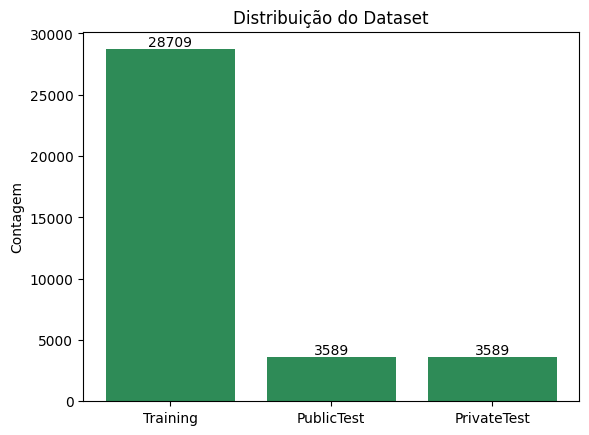

In [24]:
value_counts = df['usage'].value_counts() #total do dataset

plt.bar(value_counts.index, value_counts.values, color='seagreen') #criando barra
plt.ylabel('Contagem') #legenda
plt.title('Distribuição do Dataset') #titulo

for i, v in enumerate(value_counts.values):
  plt.text(i, v, str(v), ha='center', va='bottom') #Definindo o valor em cima da barra

plt.show()

Função para mostrar exemplos de imagens

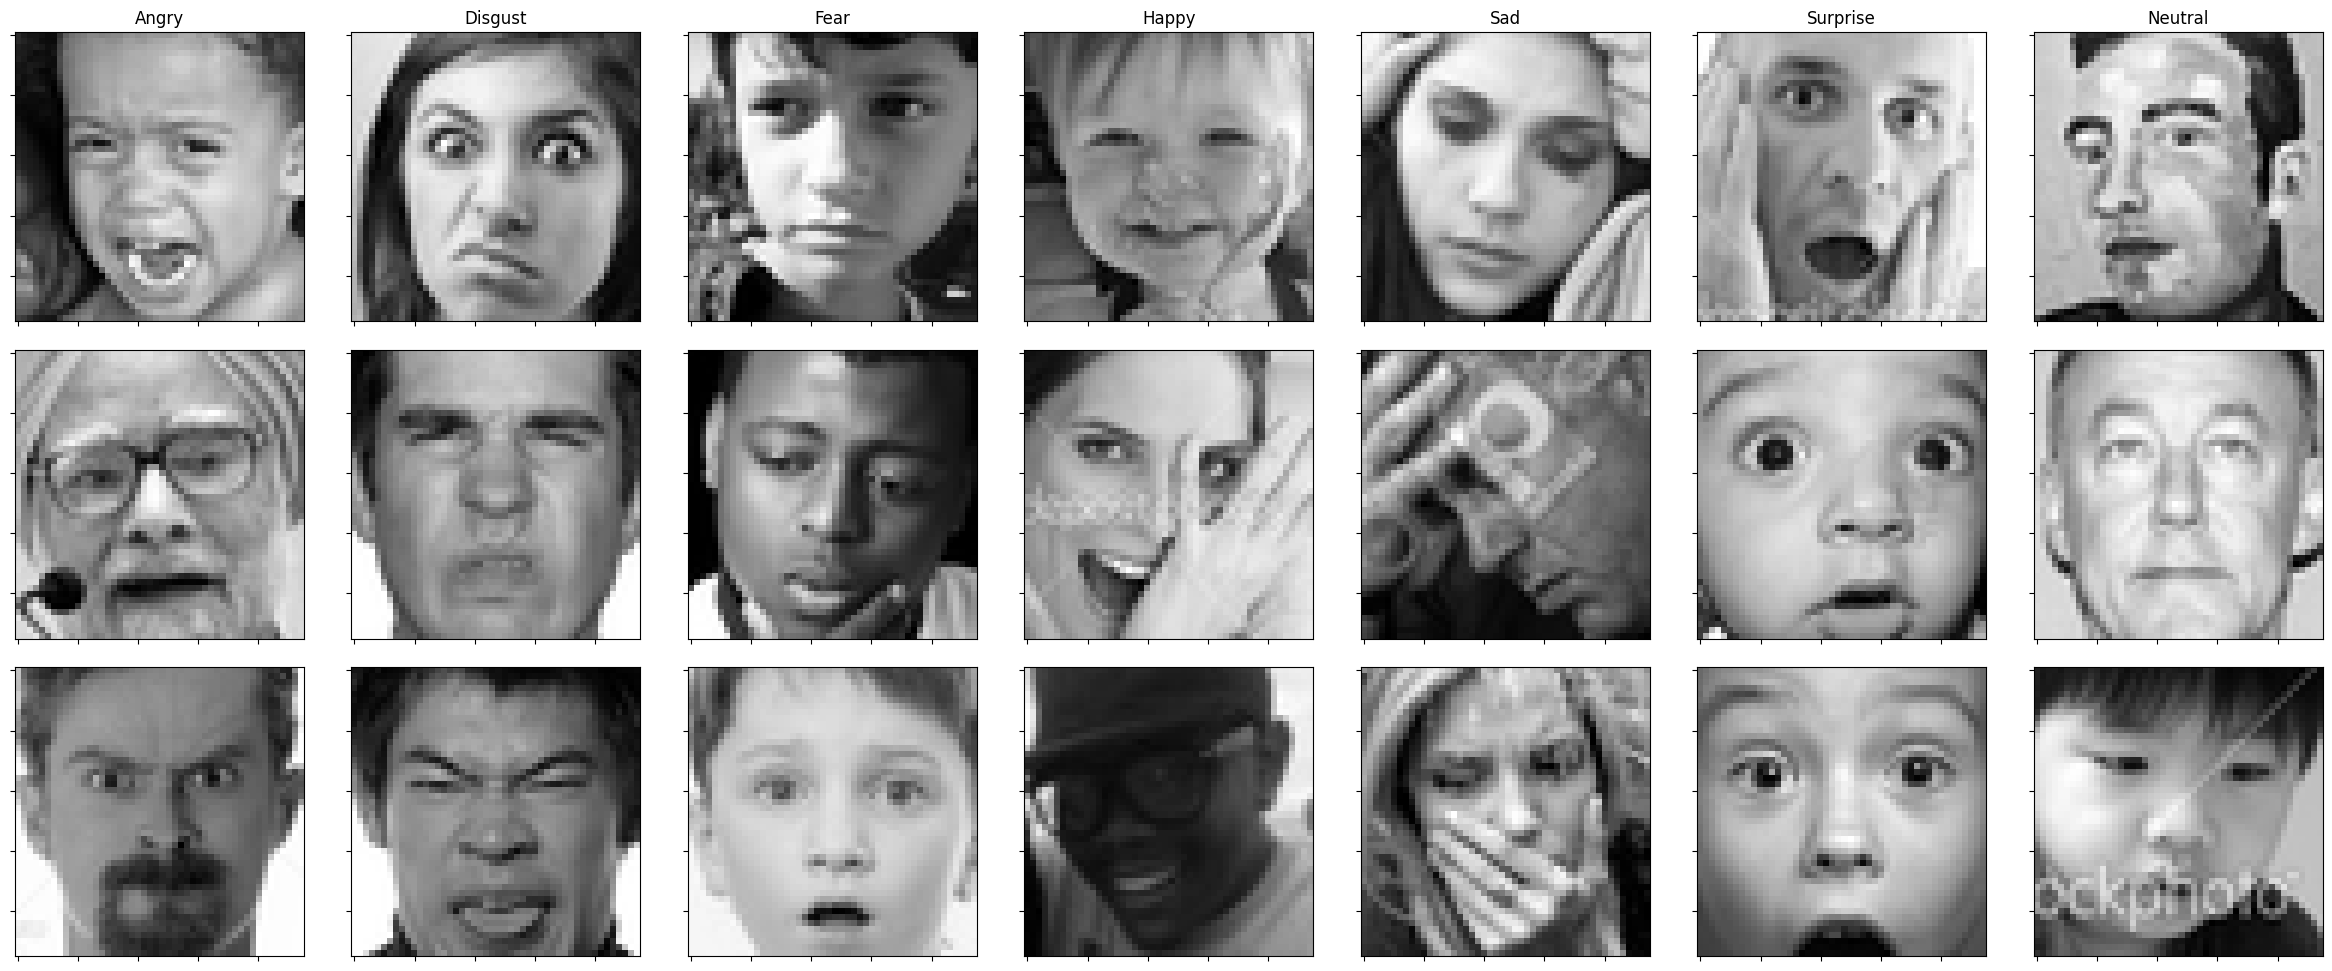

In [25]:
def mostrar_exemplos(amount):
    fig, axs = plt.subplots(3, 7, figsize=(30, 12)) #Define figura e eixo
    fig.subplots_adjust(hspace=0.1, wspace=0.1) #Ajusta espaçamento
    axs = axs.ravel()
    
    n_emotion = len(emotions.items()) #Quantidade de emoções existentes
    
    for j in range(amount):
        for i in range(n_emotion):
            random_number = random.randint(0, 100) #Valor aleatorio para gerar imagens aleatórias
            idx = df[df['emotion'] == i].index[random_number] 
            axs[j*n_emotion + i].imshow(train_images[idx][:, :, 0], cmap='gray') #Criando imagem
            axs[j*n_emotion + i].set_title(emotions[i] if j == 0 else '') #Definindo titulo
            axs[j*n_emotion + i].set_xticklabels([])
            axs[j*n_emotion + i].set_yticklabels([])
        
    plt.show() #Mostra o gráfico

mostrar_exemplos(3)

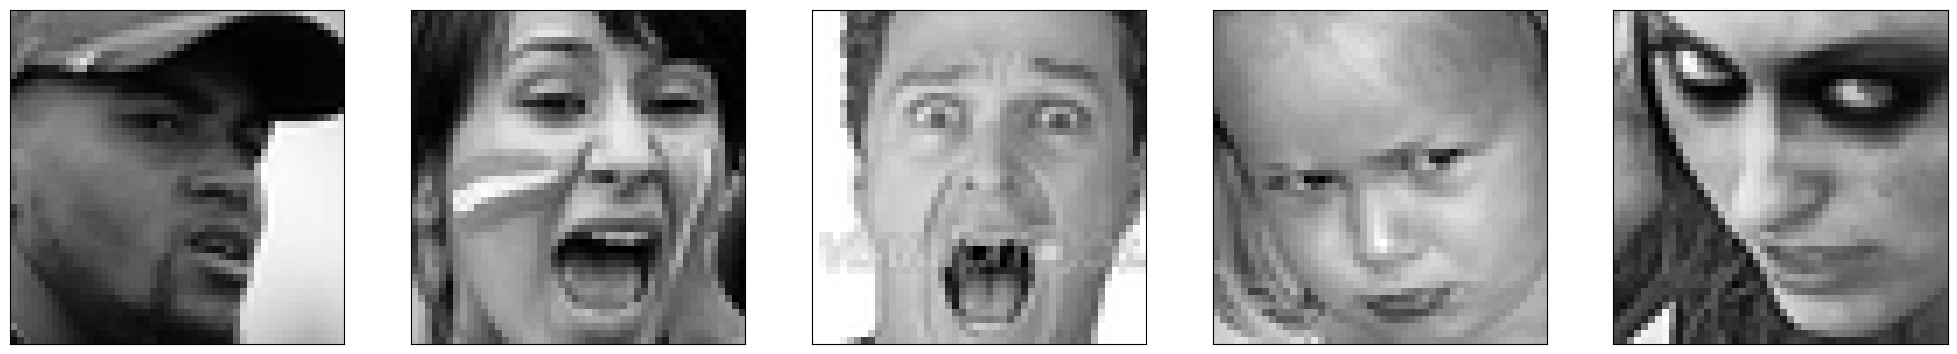

In [26]:
mostrar_categoria(label=0)

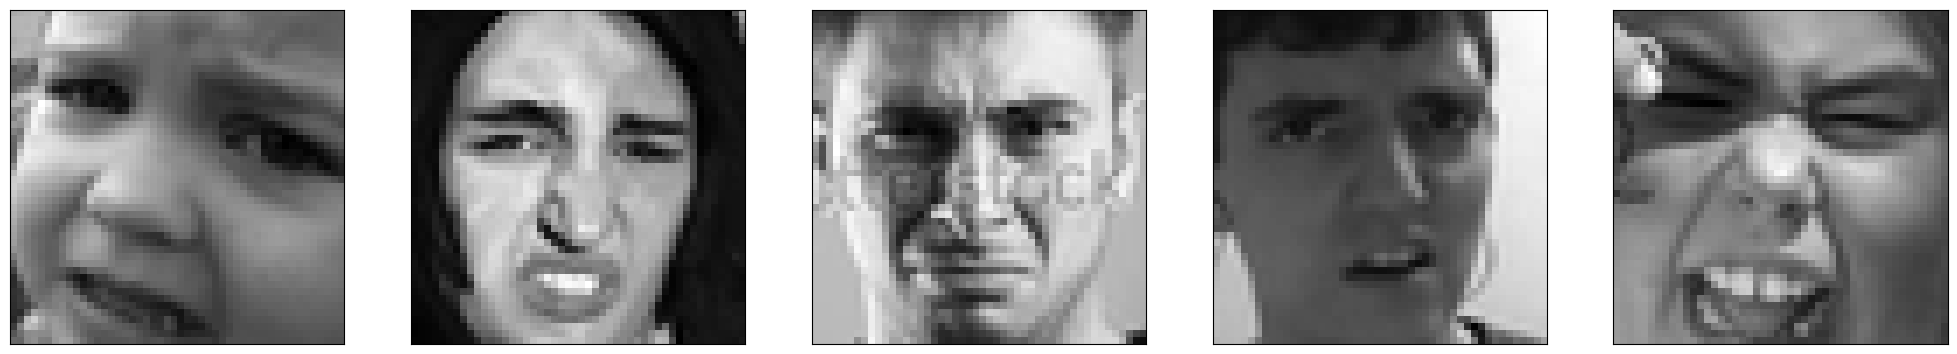

In [27]:
mostrar_categoria(label=1)

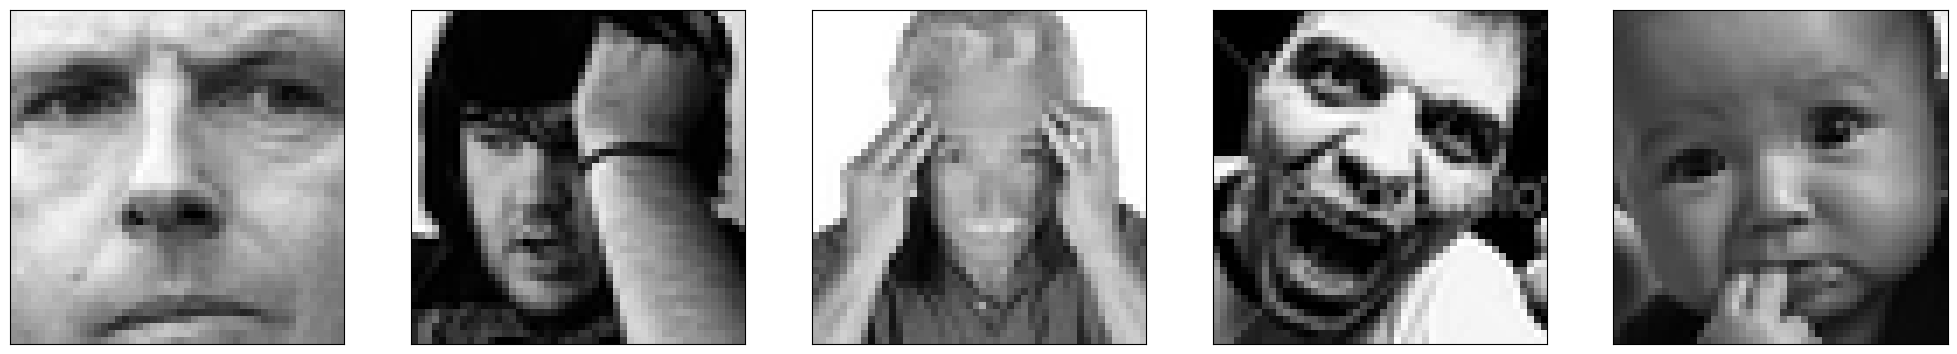

In [28]:
mostrar_categoria(label=2)

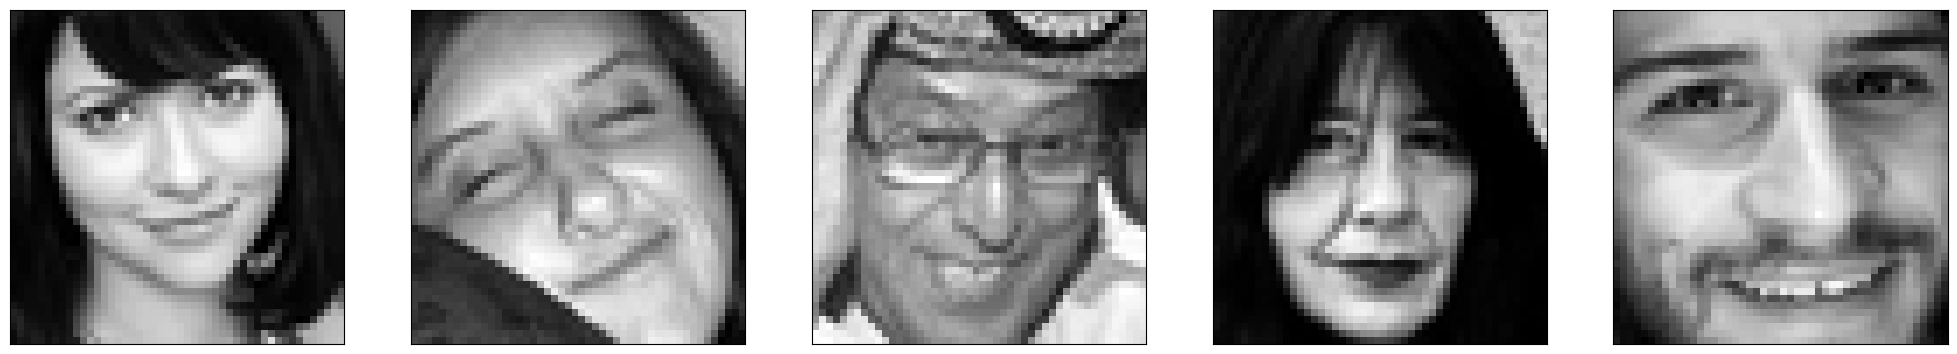

In [29]:
mostrar_categoria(label=3)

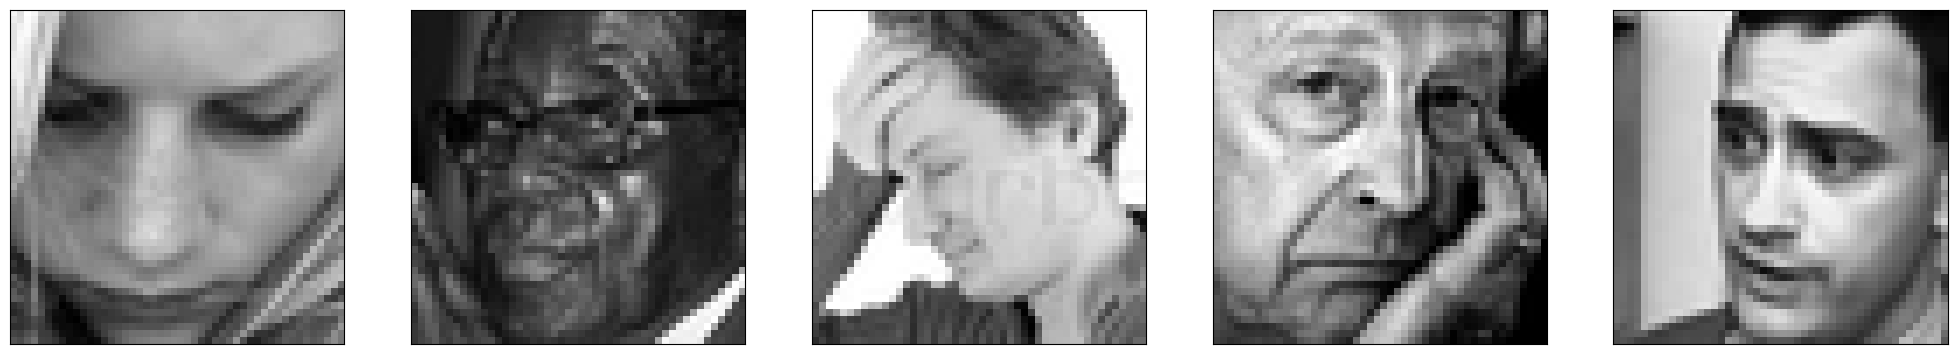

In [30]:
mostrar_categoria(label=4)

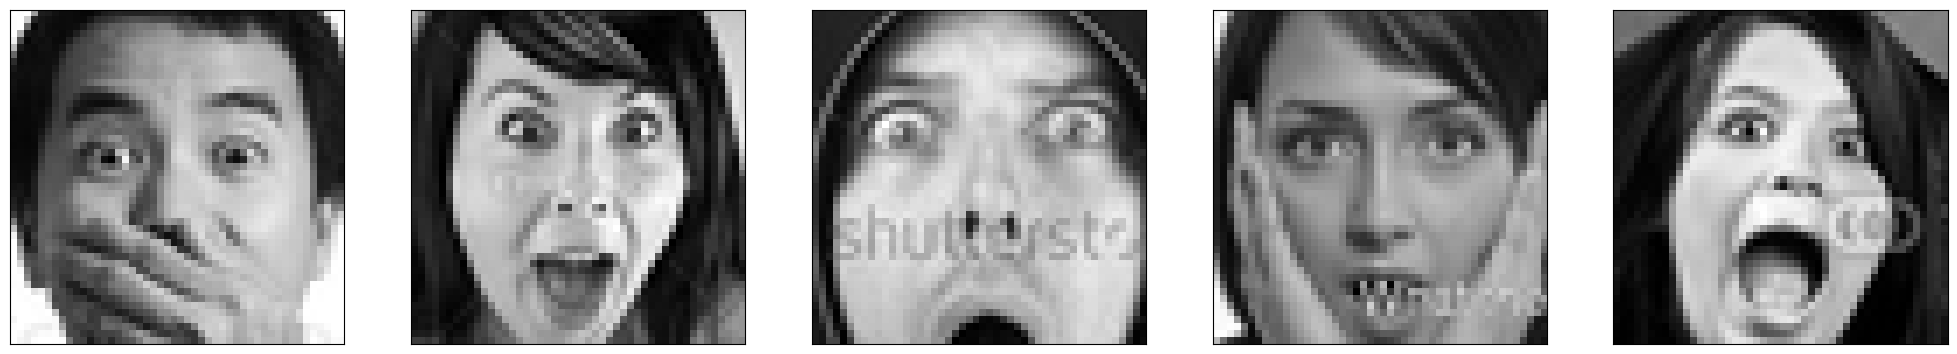

In [31]:
mostrar_categoria(label=5)

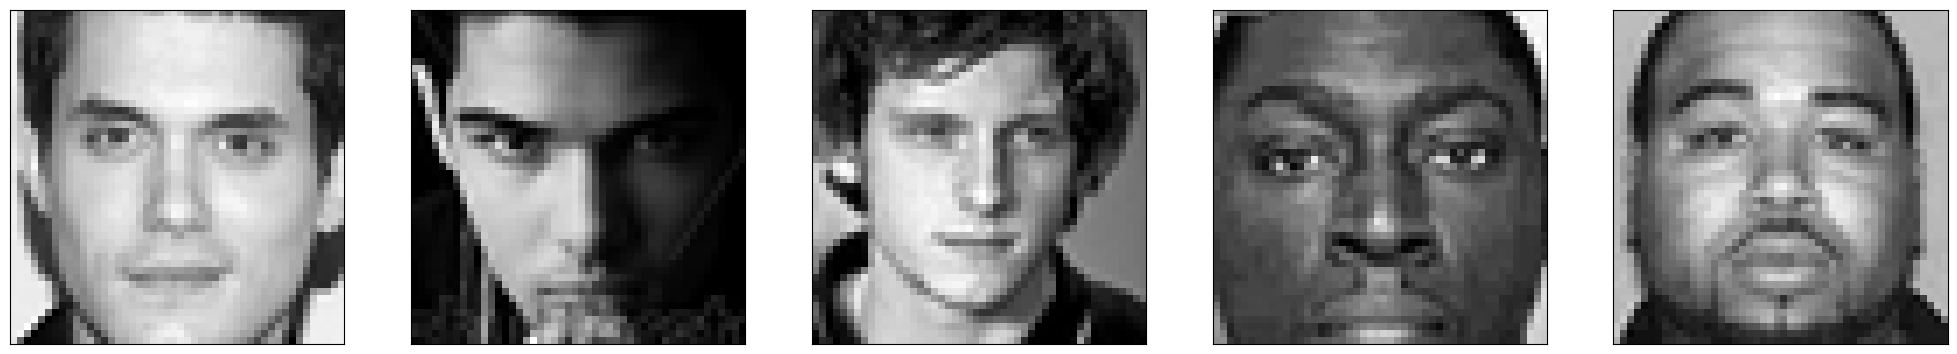

In [32]:
mostrar_categoria(label=6)

In [33]:
def compara_distrubuicao(a1, a2, t1='', t2=''):
  df1 = pd.DataFrame()
  df2 = pd.DataFrame()
  df1['emotion'] = a1.argmax(axis=1)
  df2['emotion'] = a2.argmax(axis=1)

  fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
  x = emotions.values()

  y = df1['emotion'].value_counts()
  keys_missed = list(set(emotions.keys()).difference(set(y.keys())))

  for k in keys_missed:
    y[k] = 0
  axs[0].bar(x, y.sort_index(), color='seagreen')

  for i, v in enumerate(y.sort_index()):
      axs[0].text(i, v + 1, str(v), color='black', ha='center')  

  axs[0].set_title(t1)
  axs[0].grid()

  y = df2['emotion'].value_counts()
  keys_missed = list(set(emotions.keys()).difference(set(y.keys())))  

  for k in keys_missed:
    y[k] = 0
  axs[1].bar(x, y.sort_index(), color='goldenrod')

  for i, v in enumerate(y.sort_index()):
      axs[1].text(i, v + 1, str(v), color='black', ha='center')
      
  axs[1].set_title(t2)
  axs[1].grid()


  plt.show()

Distribuição de Categorias entre Treino e Teste



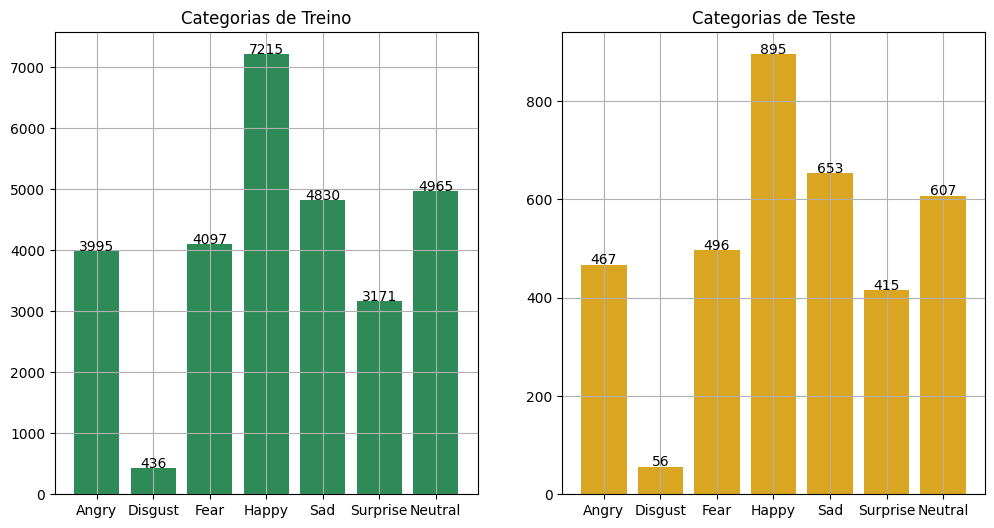

In [34]:
compara_distrubuicao(train_labels, test_labels, t1='Categorias de Treino', t2='Categorias de Teste')

Distribuição de Categorias entre Treino e Validação


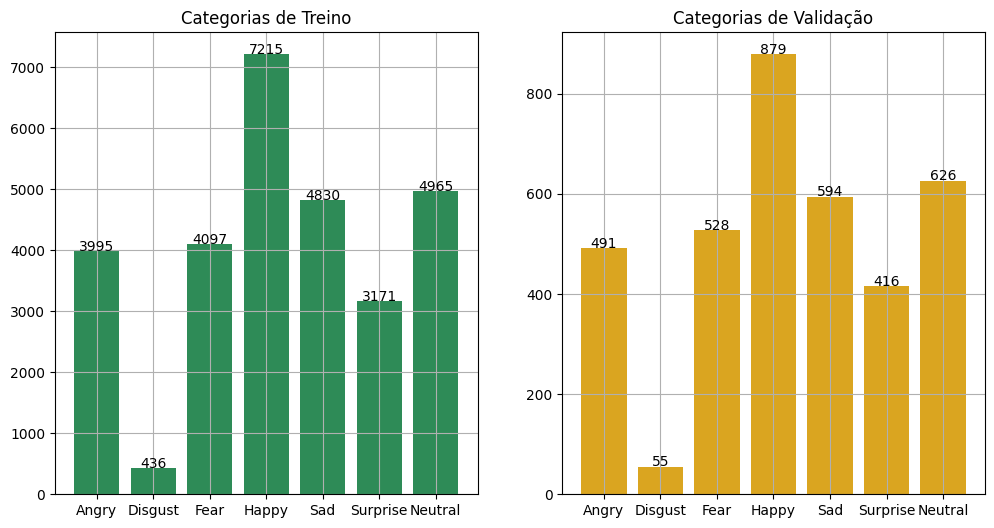

In [35]:
compara_distrubuicao(train_labels, val_labels, t1='Categorias de Treino', t2='Categorias de Validação')

# 4. Construção do Modelo

#### Teste Modelo

In [36]:
model = models.Sequential()

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model.add(MaxPool2D((2, 2)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

Criando função de retorno (callback)

In [ ]:
def model_callback(modelName):

  checkpoint = ModelCheckpoint(
      f"Checkpoints/{modelName}.h5", #Lugar onde será salvo os saves
      monitor = "val_accuracy", #Define qual métrica será observada para determinar melhores pesos
      save_best_only = True, #Apenas os melhores serão salvos
      mode = "auto", #Define se o monitor deve ser maximizado ou minimizado
      verbose = 1 #Informações no output
  )

  early_stopping = EarlyStopping(
      monitor = "val_accuracy",
      patience = 10, #Número de epoch para parar caso não houver melhorias
      verbose = 1
  )
  callbacks = [early_stopping, checkpoint]
  return callbacks

Compilando Modelo

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Treinamento o Modelo

In [ ]:
history1 = model.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    callbacks=model_callback('Modelo1'),
    class_weight = peso_categoria,
    epochs=30, #Número de vezes que o modelo passará pelo dataset
    batch_size=64 #Tamanho do lote para cada epoch
)

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.3676
Epoch 1: val_accuracy improved from -inf to 0.42352, saving model to Checkpoints/Modelo1.h5
449/449 [==============================] - 209s 467ms/step - loss: 0.2485 - accuracy: 0.3676 - val_loss: 1.5116 - val_accuracy: 0.4235
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.4618
Epoch 2: val_accuracy improved from 0.42352 to 0.49262, saving model to Checkpoints/Modelo1.h5
449/449 [==============================] - 198s 442ms/step - loss: 0.2136 - accuracy: 0.4618 - val_loss: 1.3457 - val_accuracy: 0.4926
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.5223
Epoch 3: val_accuracy did not improve from 0.49262
449/449 [==============================] - 205s 457ms/step - loss: 0.1915 - accuracy: 0.5223 - val_loss: 1.3661 - val_accuracy: 0.4854
Epoch 4/30
449/449 [==============================] - ETA: 0s - loss:

Acurácia em comparação com a validação

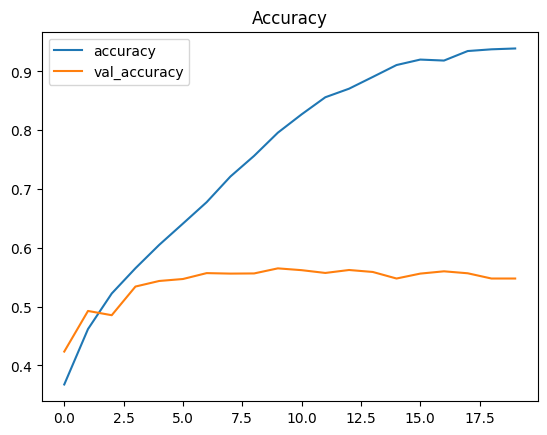

In [ ]:
pd.DataFrame(history1.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

Perda em comparação com a validação

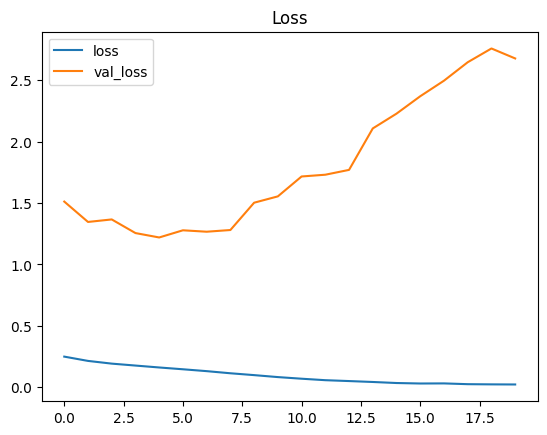

In [ ]:
pd.DataFrame(history1.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

####Teste 2 Modelo

In [49]:
# Criação do modelo
model = models.Sequential()

# Primeira camada de convolução
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))  # Adicionando Dropout

# Segunda camada de convolução
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

# Terceira camada de convolução
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

# Camada de achatamento dos dados
model.add(Flatten())

# Camada de neuronios de conexão
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Adicionando Dropout

# Camada de saída
model.add(Dense(7, activation='softmax'))

In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
def model_callback(modelName):

  checkpoint = ModelCheckpoint(
      f"Checkpoints/{modelName}.h5", #Lugar onde será salvo os saves
      monitor = "val_accuracy", #Define qual métrica será observada para determinar melhores pesos
      save_best_only = True, #Apenas os melhores serão salvos
      mode = "auto", #Define se o monitor deve ser maximizado ou minimizado
      verbose = 1 #Informações no output
  )

  early_stopping = EarlyStopping(
      monitor = "val_accuracy",
      patience = 20, #Número de epoch para parar caso não houver melhorias
      verbose = 1
  )
  callbacks = [early_stopping, checkpoint]
  return callbacks

In [52]:
history_final = model.fit(
    train_images,
    train_labels, 
    callbacks=model_callback('Modelo3'),
    validation_data=(val_images, val_labels),
    class_weight = peso_categoria,
    epochs=10,
    batch_size=32
)

Epoch 1/10
897/898 [============================>.] - ETA: 0s - loss: 0.2776 - accuracy: 0.2876
Epoch 1: val_accuracy improved from -inf to 0.37754, saving model to Checkpoints/Modelo3.h5
898/898 [==============================] - 87s 96ms/step - loss: 0.2776 - accuracy: 0.2875 - val_loss: 1.5822 - val_accuracy: 0.3775
Epoch 2/10
897/898 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.3957
Epoch 2: val_accuracy improved from 0.37754 to 0.44107, saving model to Checkpoints/Modelo3.h5
898/898 [==============================] - 91s 101ms/step - loss: 0.2372 - accuracy: 0.3957 - val_loss: 1.4376 - val_accuracy: 0.4411
Epoch 3/10
897/898 [============================>.] - ETA: 0s - loss: 0.2204 - accuracy: 0.4450
Epoch 3: val_accuracy improved from 0.44107 to 0.48370, saving model to Checkpoints/Modelo3.h5
898/898 [==============================] - 95s 106ms/step - loss: 0.2204 - accuracy: 0.4449 - val_loss: 1.3728 - val_accuracy: 0.4837
Epoch 4/10
897/898 [=========

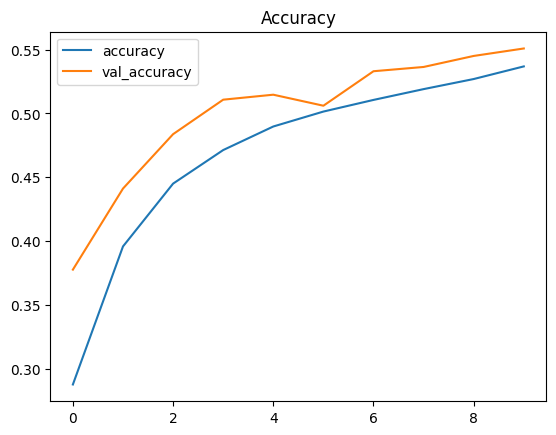

In [54]:
pd.DataFrame(history_final.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

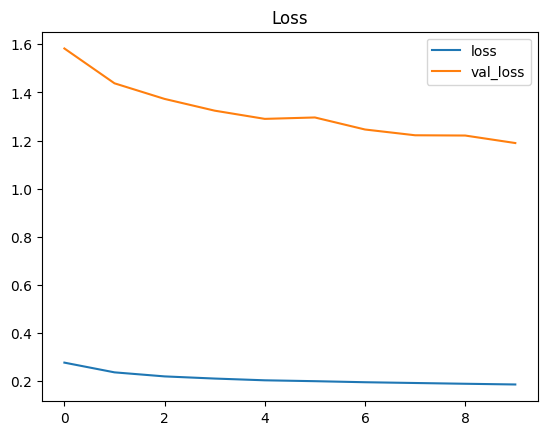

In [55]:
pd.DataFrame(history_final.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

#### Teste 3 Modelo

In [67]:
#Teste 3 Modelo without Conv2d

# Criação do modelo
model3 = models.Sequential()

# Primeira camada de convolução
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model3.add(MaxPool2D((2, 2)))
model3.add(Dropout(0.25))  # Adicionando Dropout

# Segunda camada de convolução
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPool2D((2, 2)))
model3.add(Dropout(0.25))

# Camada de achatamento dos dados
model3.add(Flatten())

# Camada de neuronios de conexão
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.25))

# Camada de saída
model3.add(Dense(7, activation='softmax'))

In [68]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
def model_callback(modelName):

  checkpoint = ModelCheckpoint(
      f"Checkpoints/{modelName}.h5", #Lugar onde será salvo os saves
      monitor = "val_accuracy", #Define qual métrica será observada para determinar melhores pesos
      save_best_only = True, #Apenas os melhores serão salvos
      mode = "auto", #Define se o monitor deve ser maximizado ou minimizado
      verbose = 1 #Informações no output
  )

  early_stopping = EarlyStopping(
      monitor = "val_accuracy",
      patience = 20, #Número de epoch para parar caso não houver melhorias
      verbose = 1
  )
  callbacks = [early_stopping, checkpoint]
  return callbacks

In [71]:
history_final = model3.fit(
    train_images,
    train_labels, 
    callbacks=model_callback('Modelo4'),
    validation_data=(val_images, val_labels),
    class_weight = peso_categoria,
    epochs=25,
    batch_size=32
)

Epoch 1/25
897/898 [============================>.] - ETA: 0s - loss: 0.2685 - accuracy: 0.3128
Epoch 1: val_accuracy improved from -inf to 0.39928, saving model to Checkpoints/Modelo4.h5
898/898 [==============================] - 75s 84ms/step - loss: 0.2685 - accuracy: 0.3128 - val_loss: 1.5749 - val_accuracy: 0.3993
Epoch 2/25
897/898 [============================>.] - ETA: 0s - loss: 0.2347 - accuracy: 0.4092
Epoch 2: val_accuracy improved from 0.39928 to 0.45639, saving model to Checkpoints/Modelo4.h5
898/898 [==============================] - 80s 89ms/step - loss: 0.2347 - accuracy: 0.4092 - val_loss: 1.4216 - val_accuracy: 0.4564
Epoch 3/25
897/898 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.4508
Epoch 3: val_accuracy improved from 0.45639 to 0.48036, saving model to Checkpoints/Modelo4.h5
898/898 [==============================] - 77s 86ms/step - loss: 0.2212 - accuracy: 0.4509 - val_loss: 1.3920 - val_accuracy: 0.4804
Epoch 4/25
897/898 [===========

Acuracia com um Overfiting após os 56%

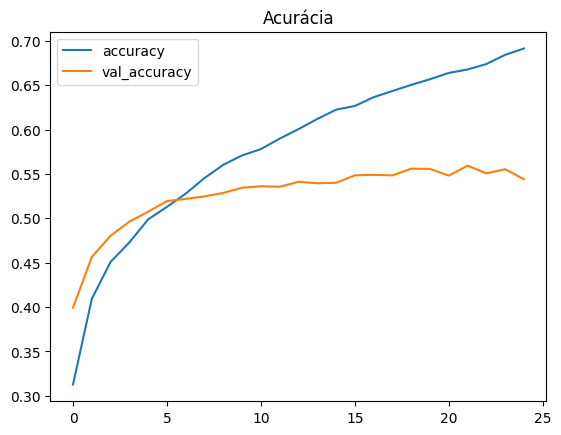

In [76]:
pd.DataFrame(history_final.history)[['accuracy','val_accuracy']].plot()
plt.title("Acurácia")
plt.show()

#5. Avaliação do Modelo

Testando o modelo

In [103]:
test_loss, test_acc = model3.evaluate(test_images, test_labels)
test_prob = model3.predict(test_images)
test_pred = np.argmax(test_prob, axis=1)
print('Acurácia de Teste:', test_acc)
print('Perda de Teste:', test_loss)

113/113 [==============================] - 2s 17ms/step
Acurácia de Teste: 0.5366397500038147
Perda de Teste: 1.331740140914917


Plotando matriz de confusão

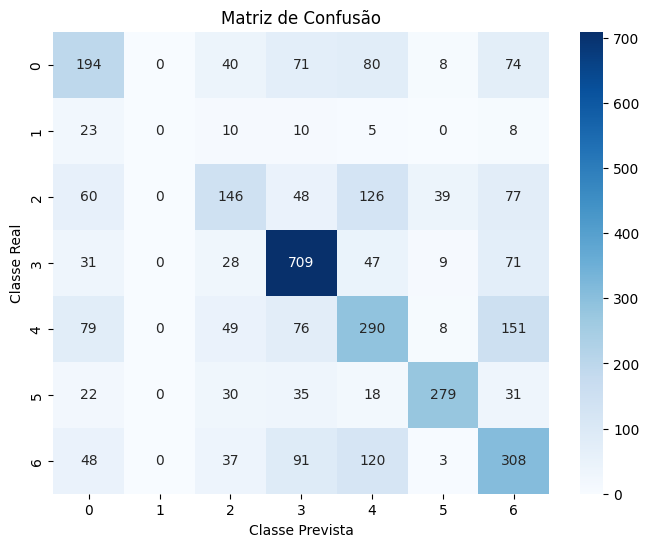

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_labels_pred = np.argmax(test_labels, axis=1)
confusion_mtx = confusion_matrix(test_labels_pred, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')

plt.title('Matriz de Confusão')
plt.show()

In [105]:
from sklearn.metrics import classification_report

# Converter as one-hot labels para rótulos numéricos
test_labels_pred = np.argmax(test_labels, axis=1)

# Calcular as métricas de avaliação
report = classification_report(test_labels_pred, test_pred)

# Exibir o relatório de classificação
print('Relatório de Classificação:')
print(report)

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.42      0.42      0.42       467
           1       0.00      0.00      0.00        56
           2       0.43      0.29      0.35       496
           3       0.68      0.79      0.73       895
           4       0.42      0.44      0.43       653
           5       0.81      0.67      0.73       415
           6       0.43      0.51      0.46       607

    accuracy                           0.54      3589
   macro avg       0.46      0.45      0.45      3589
weighted avg       0.53      0.54      0.53      3589

